In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torchvision.models as models
import itertools


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:

trainset = CIFAR10(root="./data", train=True,
                   download=True)

testset = CIFAR10(root="./data", train=False,
                  download=True)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:04<00:00, 41.6MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


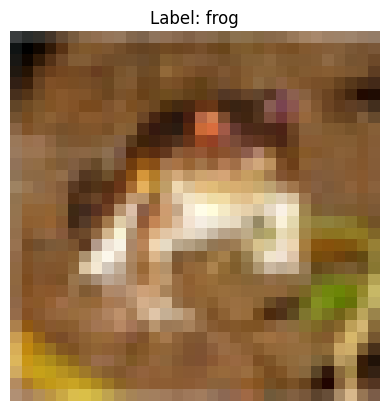

In [10]:
import matplotlib.pyplot as plt

classes = trainset.classes
print("Classes:", classes)

image, label = trainset[0]

image = image * 0.5 + 0.5

plt.imshow(image.permute(1, 2, 0))
plt.title(f"Label: {classes[label]}")
plt.axis("off")
plt.show()


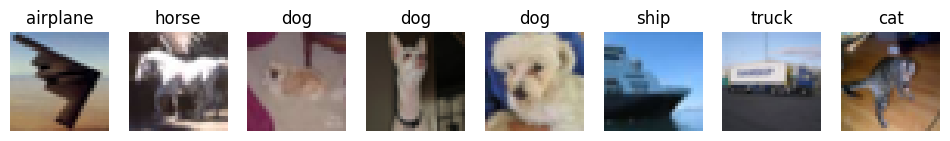

In [11]:
import numpy as np

def show_images(dataset, n=8):

    fig = plt.figure(figsize=(12, 4))

    for i in range(n):
        image, label = dataset[np.random.randint(len(dataset))]

        image = image * 0.5 + 0.5

        ax = fig.add_subplot(1, n, i+1)
        ax.imshow(image.permute(1, 2, 0))
        ax.set_title(dataset.classes[label])
        ax.axis("off")

    plt.show()

show_images(trainset, n=8)


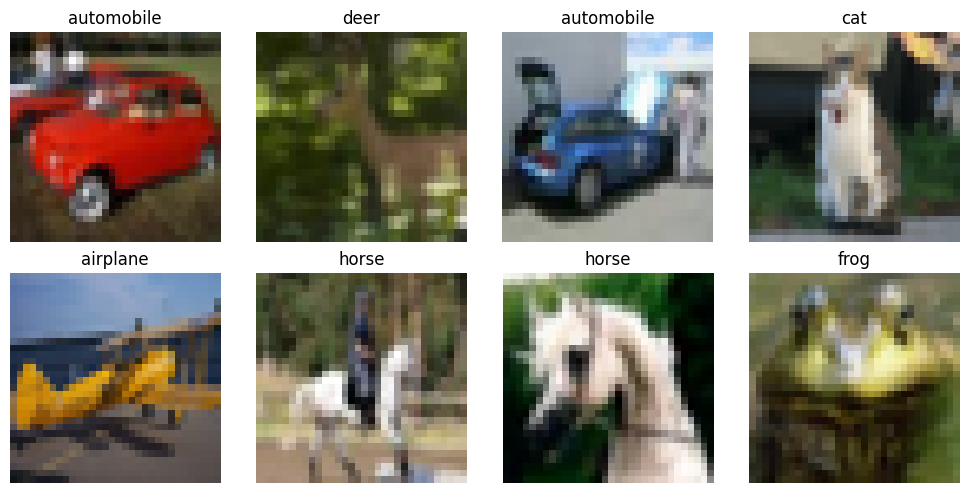

In [12]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

images = images * 0.5 + 0.5

plt.figure(figsize=(10,5))

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i].permute(1,2,0))
    plt.title(classes[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()


In [4]:
def get_cnn(activation_fn):

    model = nn.Sequential(

        nn.Conv2d(3 , 32 , kernel_size = 3 , padding = 1),
        nn.BatchNorm2d(32),
        activation_fn,
        nn.MaxPool2d(2),

        nn.Conv2d(32 , 64 , kernel_size = 3 , padding = 1),
        nn.BatchNorm2d(64),
        activation_fn,
        nn.MaxPool2d(2),

        nn.Conv2d(64 , 128 , kernel_size = 3 , padding = 1),
        nn.BatchNorm2d(128),
        activation_fn,
        nn.MaxPool2d(2),

        nn.Flatten(),
        nn.Linear(128 * 4 * 4 , 256),
        activation_fn,
        nn.Dropout(0.5),
        nn.Linear(256 , 10)
    )

    return model


In [5]:
trainset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
def initialize_weights(model, method):

    for m in model.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):

            if method == "xavier":
                nn.init.xavier_uniform_(m.weight)

            elif method == "kaiming":
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')

            elif method == "random":
                nn.init.normal_(m.weight, mean=0.0, std=0.02)

            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


In [7]:
def train_model(model, optimizer, epochs=10):

    criterion = nn.CrossEntropyLoss()
    model.to(device)

    for epoch in range(epochs):

        model.train()
        running_loss = 0

        for images, labels in trainloader:

            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(trainloader)}")


In [8]:
def evaluate(model):

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:

            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [9]:
activations = {
    "relu": nn.ReLU(),
    "tanh": nn.Tanh(),
    "leakyrelu": nn.LeakyReLU(0.01)
}

initializations = ["xavier", "kaiming", "random"]
optimizers_list = ["sgd", "adam", "rmsprop"]

best_accuracy = 0
best_model_state = None
best_config = None

for act_name, act_fn in activations.items():
    for init in initializations:
        for opt_name in optimizers_list:

            print("\n----------------------------------------------------------------")
            print(f"Running: {act_name} | {init} | {opt_name}")

            model = get_cnn(act_fn)
            initialize_weights(model, init)

            if opt_name == "sgd":
                optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
            elif opt_name == "adam":
                optimizer = optim.Adam(model.parameters(), lr=0.001)
            else:
                optimizer = optim.RMSprop(model.parameters(), lr=0.001)

            train_model(model, optimizer, epochs=5)
            accuracy = evaluate(model)

            print("Accuracy:", accuracy)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_model_state = model.state_dict()
                best_config = (act_name, init, opt_name)

print("\nBest Configuration:", best_config)
print("Best Accuracy:", best_accuracy)



----------------------------------------------------------------
Running: relu | xavier | sgd
Epoch [1/5] Loss: 1.6502966592683816
Epoch [2/5] Loss: 1.326878656664163
Epoch [3/5] Loss: 1.1419240563269466
Epoch [4/5] Loss: 1.0121072855446955
Epoch [5/5] Loss: 0.8997925358355198
Accuracy: 70.91

----------------------------------------------------------------
Running: relu | xavier | adam
Epoch [1/5] Loss: 1.5713114829929284
Epoch [2/5] Loss: 1.2382173138811154
Epoch [3/5] Loss: 1.11698462110956
Epoch [4/5] Loss: 1.0216087463414272
Epoch [5/5] Loss: 0.9492949677245391
Accuracy: 72.63

----------------------------------------------------------------
Running: relu | xavier | rmsprop
Epoch [1/5] Loss: 1.8382428184799526
Epoch [2/5] Loss: 1.2831976145429684
Epoch [3/5] Loss: 1.1173007437945022
Epoch [4/5] Loss: 1.0080152169212966
Epoch [5/5] Loss: 0.92386976814331
Accuracy: 67.07

----------------------------------------------------------------
Running: relu | kaiming | sgd
Epoch [1/5] Loss

In [13]:
torch.save(best_model_state, "best_cnn_cifar10.pth")
print("Best model saved!")


Best model saved!


In [14]:
resnet = models.resnet18(pretrained=True)

resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)

optimizer = optim.Adam(resnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(5):

    resnet.train()
    running_loss = 0

    for images, labels in trainloader:

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"ResNet Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

resnet_accuracy = evaluate(resnet)
print("ResNet Accuracy:", resnet_accuracy)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 108MB/s]


ResNet Epoch 1, Loss: 0.9582529004348819
ResNet Epoch 2, Loss: 0.6631806667922707
ResNet Epoch 3, Loss: 0.5283177520155602
ResNet Epoch 4, Loss: 0.42778942333844006
ResNet Epoch 5, Loss: 0.3383607640481361
ResNet Accuracy: 79.85
